# 生成モデル (Generative model)

- 訓練データを学習し，それらのデータと似たような新しいデータを生成するモデル
- 訓練データの分布と生成データの分布が一致するように学習していく

生成モデルの例

- GAN (Generative Adversarial Network) →今回やるやつ
    - 学習が不安定
    - 鮮明な画像が生成される傾向
- VAE (Variational Autoencoder)
    - 

## GANについて

- GAN https://arxiv.org/abs/1406.2661

- Generator
    - 訓練データと同じようなデータを生成しようとする
- Discriminator
    - Generatorが生成したデータを分類する

ここにGANのモデル図と例が入る

$Generator$ はノイズを含んだデータ $z$ を入力としてデータを生成

$Discriminator$ は訓練データ $x$ と生成データ $Generator(z)$ を識別する確率を最大化

→　$Generator$ は $\log(1 - Discriminator(Generator(z)))$ を最小化


1. $Discriminator$がうまく分類できるようになると
2. $Discriminator(x)$が大きくなる
3. $\log(Discriminator(x))$が大きくなる
4. $Discriminator(Generator(z))$が小さくなる
5. $\log(1 - Discriminator(Generator(z)))$は大きくなる


1. $Generator$が訓練データに類似したものを生成できるようになると
2. $Discriminator$がうまく分類できなくなる
3. $Discriminator(Generator(z))$が大きくなる
4. $\log(1 - Discriminator(Generator(z)))$は小さくなる


## DCGAN (Deep Convolutional GAN)

- CNNを使ったモデル
- 学習が難しいらしい

学習をうまく進めるテクニック(http://arxiv.org/abs/1511.06434)

- CNNのmax poolingを使わず，Discriminatorではストライド2のConvolutionにする
    - Generatorではdeconvolutionを用いて，アップサンプリングを行う

- 全結合層をなくす
    - CNNの最後の層では全結合層を使い分類を行うことが多い
        - ex) AlexNet, VGG
    
    - Discriminatorでは，Global average poolingを使う
        - Global average pooling(https://arxiv.org/abs/1312.4400)
            - 結合を行わず，一つの特徴に一つのクラスを対応づけることで分類
            - 特徴ごとの平均を取り，そのベクトルをsoftmaxで分類
            
        - 何がいいの？
            - 全結合層ではドロップアウトを使って過学習を防ぐ必要があるが，Global average poolingではらメータがなくなるので，そもそも過学習を防ぐ
            
        - 問題点
            - 安定性は増すけど収束が遅くなってしまうらしい(http://arxiv.org/abs/1511.06434)


- Batch Normalizationを使う
    - 各層でのデータ分布を正規化
    - 学習を早くしたり，パラメータの初期化をあんまり気にしなくてもよくなる
    - 過学習を防ぐ
    
    - Generatorの出力層とDiscriminatorの入力層以外に適用
        - 全部に適用すると不安定になるらしい
        
        
    - 反論1:http://qiita.com/t-ae/items/236457c29ba85a7579d5
    - 反論2:http://torch.ch/blog/2015/11/13/gan.html

- Leaky ReLUを使う
    - Generatorでは活性化関数にReLU，出力層にTanh
    - Discriminatorでは全ての層でLeaky ReLU
    - Leaky ReLUって何
        - ReLUは $f(x) = max(0,x)$
        - Leaky ReLUは $f(x) = max(\alpha{x}, x)$
            - DCGANでは $\alpha = 0.2$
                - この$\alpha$も一緒に学習しようぜ！→ PReLU → 過学習のリスク(http://arxiv.org/abs/1505.00853)
                
    - 何がいいの
        - $x \le 0$ の領域では勾配が0になってしまうので誤差逆伝播が止まり，学習が進まなくなる
        - それを回避できる
        

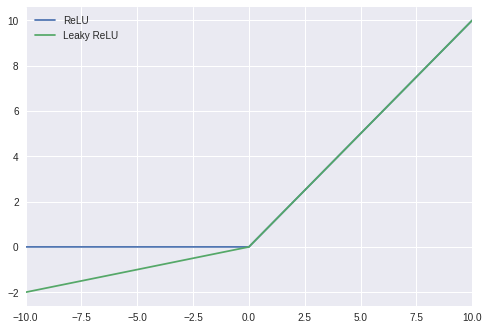

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close('all')
x = list(range(-10, 11))
relu = list(map(lambda x: max(0, x), x))
leaky_relu = list(map(lambda x: max(0.2*x, x), x))
plt.plot(x, relu, label='ReLU')
plt.plot(x, leaky_relu, label='Leaky ReLU')
plt.xlim(-10, 10)
plt.legend()
plt.show()

### 実装

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout
import numpy as np

import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

#### Generator

In [50]:
def dcgan_generator():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((128, 7, 7), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2))) # upsampling
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2))) # upsampling
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    
    return model

In [51]:
dcgan_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_17 (Dense)                 (None, 1024)          103424      dense_input_5[0][0]              
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorma(None, 1024)          2048        dense_17[0][0]                   
____________________________________________________________________________________________________
activation_21 (Activation)       (None, 1024)          0           batchnormalization_13[0][0]      
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 6272)          6428800     activation_21[0][0]              
___________________________________________________________________________________________

#### Discriminator

In [39]:
def dcgan_discriminator():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5,
                            subsample=(2, 2), # ストライド2のConvolution
                            border_mode='same',
                            input_shape=(1, 28, 28)))
    model.add(LeakyReLU(0.2)) # LeakyReLU
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

#### train

In [52]:
BATCH_SIZE = 32
NUM_EPOCH = 20
GENERATED_IMAGE_PATH = './' # 生成画像の保存先

(X_train, y_train), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])

discriminator = dcgan_discriminator()
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

In [53]:
# generator+discriminator （discriminator部分の重みは固定）
discriminator.trainable = False
generator = dcgan_generator()
dcgan = Sequential([generator, discriminator])
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

In [54]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)
for epoch in range(NUM_EPOCH):

    for index in range(num_batches):
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = generator.predict(noise, verbose=0)

        # 生成画像を出力
        if index % 500 == 0:
            image = combine_images(generated_images)
            image = image*127.5 + 127.5
            if not os.path.exists(GENERATED_IMAGE_PATH):
                os.mkdir(GENERATED_IMAGE_PATH)
            Image.fromarray(image.astype(np.uint8))\
                .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))

        # discriminatorを更新
        X = np.concatenate((image_batch, generated_images))
        y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)

        # generatorを更新
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
        print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))


Number of batches: 1875


ValueError: GpuDnnConv images and kernel must have the same stack size

Apply node that caused the error: GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 156
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), <theano.gof.type.CDataType object at 0x7fef60719c88>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(32, 14, 28, 128), (1, 64, 5, 5), (32, 1, 28, 128), 'No shapes', (), ()]
Inputs strides: [(50176, 3584, 128, 1), (0, 25, 5, 1), (3584, 0, 128, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <capsule object NULL at 0x7fef89fd5570>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{Composite{tanh((i0 + i1))}}[(0, 0)](GpuDnnConv{algo='small', inplace=True}.0, GpuReshape{4}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [47]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)
for epoch in range(NUM_EPOCH):
    print(epoch)
    for index in range(num_batches):
        print(index)
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        print(noise)
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = generator.predict(noise, verbose=0)

        # 生成画像を出力
        if index % 500 == 0:
            image = combine_images(generated_images)
            image = image*127.5 + 127.5
            if not os.path.exists(GENERATED_IMAGE_PATH):
                os.mkdir(GENERATED_IMAGE_PATH)
            Image.fromarray(image.astype(np.uint8))\
                .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))

        # discriminatorを更新
        X = np.concatenate((image_batch, generated_images))
        y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)

        # generatorを更新
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
        print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))


Number of batches: 1875
0
0
[[ 0.74888697  0.94080606 -0.71759658 ...,  0.31654719 -0.8231424
  -0.28386684]
 [ 0.20464562  0.77707177 -0.51164529 ..., -0.22503885 -0.99439603
  -0.04935416]
 [-0.18099452 -0.49045199 -0.74996024 ..., -0.95131976 -0.58509431
  -0.0556051 ]
 ..., 
 [ 0.83353399  0.01057736 -0.42461295 ..., -0.80226604  0.92488151
  -0.7028039 ]
 [ 0.90573408 -0.09612826  0.0462544  ...,  0.06732609 -0.2282875
   0.78568906]
 [-0.3293857   0.25730791 -0.59582821 ...,  0.86767805  0.46681391
  -0.89736135]]


ValueError: GpuDnnConv images and kernel must have the same stack size

Apply node that caused the error: GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 156
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), <theano.gof.type.CDataType object at 0x7fef54bde828>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(32, 14, 28, 128), (1, 64, 5, 5), (32, 1, 28, 128), 'No shapes', (), ()]
Inputs strides: [(50176, 3584, 128, 1), (0, 25, 5, 1), (3584, 0, 128, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <capsule object NULL at 0x7fef7f1ff690>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{Composite{tanh((i0 + i1))}}[(0, 0)](GpuDnnConv{algo='small', inplace=True}.0, GpuReshape{4}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [55]:
BATCH_SIZE = 32
NUM_EPOCH = 20
GENERATED_IMAGE_PATH = './' # 生成画像の保存先

def train():
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])

    discriminator = dcgan_discriminator()
    d_opt = Adam(lr=1e-5, beta_1=0.1)
    discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

    # generator+discriminator （discriminator部分の重みは固定）
    discriminator.trainable = False
    generator = dcgan_generator()
    dcgan = Sequential([generator, discriminator])
    g_opt = Adam(lr=2e-4, beta_1=0.5)
    dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

    num_batches = int(X_train.shape[0] / BATCH_SIZE)
    print('Number of batches:', num_batches)
    for epoch in range(NUM_EPOCH):

        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)

            # 生成画像を出力
            if index % 500 == 0:
                image = combine_images(generated_images)
                image = image*127.5 + 127.5
                if not os.path.exists(GENERATED_IMAGE_PATH):
                    os.mkdir(GENERATED_IMAGE_PATH)
                Image.fromarray(image.astype(np.uint8))\
                    .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))

            # discriminatorを更新
            X = np.concatenate((image_batch, generated_images))
            y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)

            # generatorを更新
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
            print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))

        generator.save_weights('generator.h5')
        discriminator.save_weights('discriminator.h5')

In [56]:
train()

Number of batches: 1875


ValueError: GpuDnnConv images and kernel must have the same stack size

Apply node that caused the error: GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 156
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), <theano.gof.type.CDataType object at 0x7fef60df90b8>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(32, 14, 28, 128), (1, 64, 5, 5), (32, 1, 28, 128), 'No shapes', (), ()]
Inputs strides: [(50176, 3584, 128, 1), (0, 25, 5, 1), (3584, 0, 128, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <capsule object NULL at 0x7fef54ddf1e0>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{Composite{tanh((i0 + i1))}}[(0, 0)](GpuDnnConv{algo='small', inplace=True}.0, GpuReshape{4}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## LAPGAN

- CNNを使って高解像度画像の生成に成功(DCGANよりも先)
- 何回かに分けて画像を生成する必要があった